In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter

try:
    import tensorboard
except ImportError:
    %pip install tensorboard
    import tensorboard

import subprocess
cmd = ["tensorboard", "--logdir=runs"]
tensorboard_process = subprocess.Popen(cmd)
print("TensorBoard is running. You can access it at http://localhost:6006")

import sklearn
from sklearn.datasets import load_digits

import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt

import netCDF4 as nc

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go

from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans
import hdbscan

import cv2

TensorBoard is running. You can access it at http://localhost:6006


In [3]:
# Clustering parameters
DHR_variables = ['DHR1020', 'DHR443', 'DHR490', 'DHR565', 'DHR670', 'DHR865']

clustering_variables = DHR_variables + ['NDVI'] # Define the variables used for clustering
# clustering_variables = ['Ross_Li_BRDF_670_geometric_parameter', 'DHR670', 'SSA670', 'AAOD670', 'AODF1020', 'AExp', 'NDVI']
# clustering_variables = ['Water_Fraction_C', 'BrC_Fraction_C', 'Insoluble_Fraction_C', 'Iron_Fraction_C', 'NDVI']

num_clusters = 10   # Define the number of clusters

# Data parameters
selection = 'land' # Define the selection of the data (land, sea, both)

# Autoencoder parameters

input_dim = len(clustering_variables) # Define the input dimension of the autoencoder
n_latent = 2
n_hidden = input_dim

LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
print(f"Number of latent variables: {n_latent}")
print(f"Number of hidden neurons: {n_hidden}")
print(f"Variables used for clustering: {clustering_variables}")


Using cuda device
Number of latent variables: 2
Number of hidden neurons: 7
Variables used for clustering: ['DHR1020', 'DHR443', 'DHR490', 'DHR565', 'DHR670', 'DHR865', 'NDVI']


In [58]:
def normalize(data):
  return (data - data.mean()) / data.std()

def get_data(selection, clustering_variables, filename='data/GRASP_POLDER_L3_climatological_S1.1degree.nc', fill_value=-1000):
    """ Loads the data from the GRASP netCDF file and returns a pandas dataframe with the selected variables and the latitude and longitude """
    
    original_dataset = nc.Dataset(filename)
    img_shape = original_dataset.variables['DHR1020'][:].shape # we will use this to flatten the variables and get the shape back later

    # mask creation, to select the land or the sea or both
    if selection == 'sea':
        mask = (original_dataset.variables['LandPercentage'][:] == 100).filled(True)
    elif selection == 'land':
        mask = (original_dataset.variables['LandPercentage'][:] != 100).filled(True)
    else:
        mask = original_dataset.variables['DHR1020'][:].mask

    # flattening the variables / masking
    data = {}
    for var in original_dataset.variables:
        if original_dataset[var][:].shape == img_shape: # we only want the variables with the same shape as the image
            data[var] = original_dataset[var][:].flatten()
            data[var][mask.flatten()] = fill_value

    # creating the dataframe
    df = pd.DataFrame(data)
    #del data, original_dataset # free some memory

    # we explicitly set the fill_value to nan
    df = df.replace(fill_value, np.nan)
    df = df[clustering_variables + ['Latitude', 'Longitude']]
    df.dropna(inplace=True)
    data = df[clustering_variables].values
    data = normalize(data)
    return data, df

In [59]:
# Load the data
file_path = 'data/GRASP_POLDER_L3_climatological_S1.1degree.nc'
data, df = get_data('both', clustering_variables, file_path, fill_value=-1000)
dataset = torch.utils.data.DataLoader(data, batch_size = BATCH_SIZE, shuffle=True)

In [60]:
class VAE(nn.Module):
    """ Implementation of a Variational Autoencoder """

    def __init__(self, input_dim, hidden_dim, latent_dim):

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            )
        
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim))
         
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(std).to(device)
        z = mean + std*epsilon
        return z

    
    def forward(self, x):
        x = self.encoder.forward(x)
        mu, logvar = self.mean_layer(x), self.logvar_layer(x)
        z = self.reparameterization(mu, logvar)
        x_hat = self.decoder.forward(z)
        return x_hat, mu, logvar


In [61]:
model = VAE(input_dim, hidden_dim=input_dim, latent_dim=n_latent)
optimizer = optim.Adam(model.parameters(), LR)
model


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=7, bias=True)
  )
  (mean_layer): Linear(in_features=7, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=7, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=7, bias=True)
  )
)

In [62]:
alpha = 1e-6 # define the weight of the divergence metric

def ressemblance_metric(x, x_hat):
    return torch.mean((x - x_hat)**2)

def divergence_metric(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [490]:
def train_model(model, dataset, optimizer, EPOCHS, verbose=True):
    """ Trains the model on the dataset for a given number of epochs """

    model.train().to(device)
    writer = SummaryWriter() # tensorboard writer, to show the diffrerent histograms / metrics during the training

    for epoch in range(EPOCHS):

        # Metrics
        losses = []
        mses = []
        ressemblances = []
        divergences = []

        for batch in dataset:
            batch = batch.to(device)
            optimizer.zero_grad()

            x_hat, mean, logvar = model.forward(batch)

            # Loss
            ressemblance = ressemblance_metric(batch, x_hat)
            divergence = divergence_metric(mean, logvar)
            loss = ressemblance + alpha*divergence

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Metrics
            batch_mse = F.mse_loss(batch, x_hat)
            losses.append(loss.item())
            mses.append(batch_mse.item())
            ressemblances.append(ressemblance.item())
            divergences.append(divergence.item()*alpha)

        # Metrics
        mean_mse = np.mean(mses)
        rsquared = 1 - mean_mse/batch.var()
        mean_loss = np.mean(losses)
        writer.add_scalar('Loss/train', mean_loss, epoch)
        writer.add_scalar('MSE/train', mean_mse, epoch)
        writer.add_scalar('R2/train', rsquared, epoch)
        writer.add_scalar('Ressemblance/train', np.mean(ressemblances), epoch)
        writer.add_scalar('Divergence/train', np.mean(divergences), epoch)

        # Histograms
        writer.add_histogram('Mean', mean, epoch)
        writer.add_histogram('Logvar', logvar, epoch)
        writer.add_histogram('x_hat', x_hat, epoch)
        writer.add_histogram('x', batch, epoch)

        if verbose:
            print(f'Epoch N°{epoch}/{EPOCHS} ; MSE : {mean_mse:.4f} ; Rsquared : {rsquared:.4f}; Average loss : {mean_loss:.4f}; Ressemblance : {np.mean(ressemblances):.4f}; Divergence : {np.mean(divergences):.4f}')

    # with open('clusters.html', 'r') as f:
    #     html_content = f.read()
    # writer.add_text("Plotly Graph", html_content, global_step=0)

In [64]:
train_model(model, dataset, optimizer, EPOCHS, verbose=True)

Epoch N°0/30 ; MSE : 0.9544 ; Rsquared : -0.1364; Average loss : 0.9550; Ressemblance : 0.9544; Divergence : 0.0006
Epoch N°1/30 ; MSE : 0.4988 ; Rsquared : 0.6180; Average loss : 0.5047; Ressemblance : 0.4988; Divergence : 0.0059
Epoch N°2/30 ; MSE : 0.1932 ; Rsquared : 0.8348; Average loss : 0.2000; Ressemblance : 0.1932; Divergence : 0.0068
Epoch N°3/30 ; MSE : 0.1396 ; Rsquared : 0.8950; Average loss : 0.1443; Ressemblance : 0.1396; Divergence : 0.0046
Epoch N°4/30 ; MSE : 0.0841 ; Rsquared : 0.9340; Average loss : 0.0880; Ressemblance : 0.0841; Divergence : 0.0039
Epoch N°5/30 ; MSE : 0.0570 ; Rsquared : 0.9427; Average loss : 0.0608; Ressemblance : 0.0570; Divergence : 0.0038
Epoch N°6/30 ; MSE : 0.0473 ; Rsquared : 0.9524; Average loss : 0.0512; Ressemblance : 0.0473; Divergence : 0.0039
Epoch N°7/30 ; MSE : 0.0422 ; Rsquared : 0.9569; Average loss : 0.0463; Ressemblance : 0.0422; Divergence : 0.0041
Epoch N°8/30 ; MSE : 0.0373 ; Rsquared : 0.9592; Average loss : 0.0413; Ressemb

KeyboardInterrupt: 

C:\Users\Mathis\AppData\Local\Temp\ipykernel_16124\2823132911.py:10: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



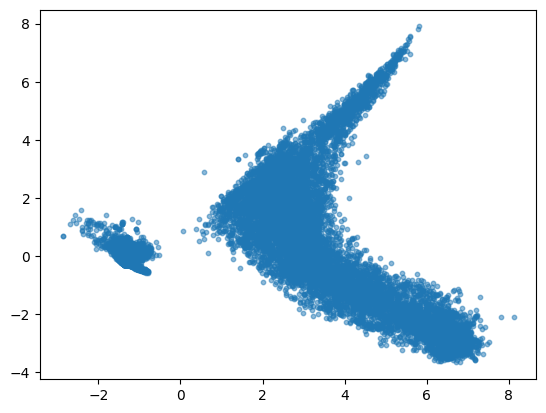

MSE : 0.0083 ; R2 : 0.9917


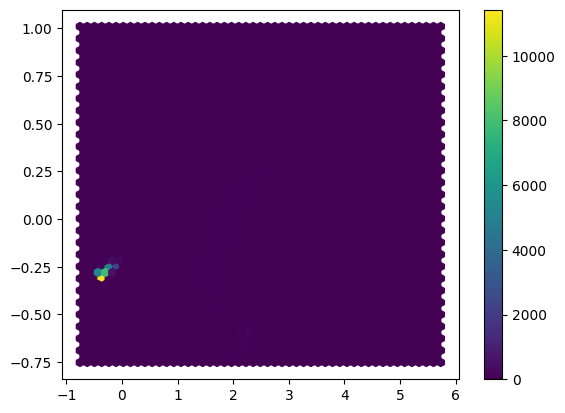

In [65]:
# we compare to a PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# Create a color map for the different numbers
cmap = plt.get_cmap('tab10')

# use the same data as before
pca_data = pca.fit_transform(data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap=cmap, s=10, alpha=0.5)
plt.show()

# Inverse transform
pca_data = pca.inverse_transform(pca_data)

MSE = F.mse_loss(torch.Tensor(pca_data), torch.Tensor(data))
R2 = 1 - MSE/data.var()
print(f'MSE : {MSE.mean():.4f} ; R2 : {R2.mean():.4f}')

# make an hexbin plot
plt.hexbin(pca_data[:, 0], pca_data[:, 1], cmap='viridis', gridsize=50)
plt.colorbar()
plt.show()

In [ ]:
# make the predictions over the dataset to get the latent variables
model.eval()
with torch.no_grad():
    _, mean, logvar = model.forward(torch.Tensor(data).to(device))

In [432]:
# import kmeans 
from utils import plot_variable, show_results

kmeans = KMeans(n_clusters=20)
kmeans.fit(mean.cpu().detach().numpy())
labels = kmeans.labels_
t = df.copy()[clustering_variables]
t.dropna(inplace=True)

t['clusters'] = labels
t['Latitude'] = df['Latitude']
t['Longitude'] = df['Longitude']

c:\Users\Mathis\.conda\envs\ProjetTunnel\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [250]:
import numpy as np
import plotly.graph_objs as go

def make_density_plot(x, y, x_center, y_center, filename=None, nbins=20):
    # Calculate 2D density
    density, xedges, yedges = np.histogram2d(x, y, bins=nbins, density=True)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    # Create a 3D surface plot
    surface = go.Surface(x=xcenters, y=ycenters, z=density.T)

    # Create spikes for x_center and y_center
    spikes_x = []
    spikes_y = []
    spikes_z = []
    for xc, yc in zip(x_center, y_center):
        spikes_x.extend([xc, xc, None])
        spikes_y.extend([yc, yc, None])
        spikes_z.extend([0, density.max(), None])

    spikes = go.Scatter3d(
        x=spikes_x,
        y=spikes_y,
        z=spikes_z,
        mode='lines',
        line=dict(color='red', width=2),
        name='Dirac Deltas'
    )

    # Create layout
    layout = go.Layout(
        title='3D Density Surface Plot with Dirac Deltas',
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Density')
        )
    )

    # Create figure and plot
    fig = go.Figure(data=[surface, spikes], layout=layout)
    fig.show()
    if filename:
        fig.write_html(filename)
        import webbrowser
        webbrowser.open_new_tab(filename)


make_density_plot(x, y, kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'density_plot_with_centers.html', nbins=100)

In [251]:
decoded_clusters = model.decoder(torch.Tensor(kmeans.cluster_centers_).to(device))
decoded_clusters = decoded_clusters.cpu().detach().numpy()

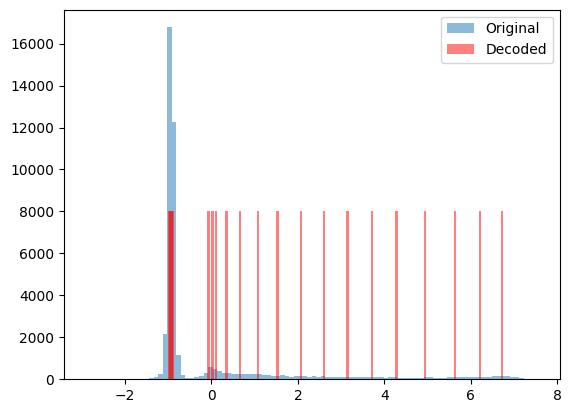

In [252]:
k = 6
x_decoded = decoded_clusters[:, k]
x = data[:, k]
# show an histogram of the original data and plot the decoded data on top
plt.hist(x, bins=100, alpha=0.5, label='Original')
plt.bar(x_decoded, 8000*np.ones_like(x_decoded), width=(x.max()-x.min())/200, alpha=0.5, label='Decoded', color='red')
plt.legend()

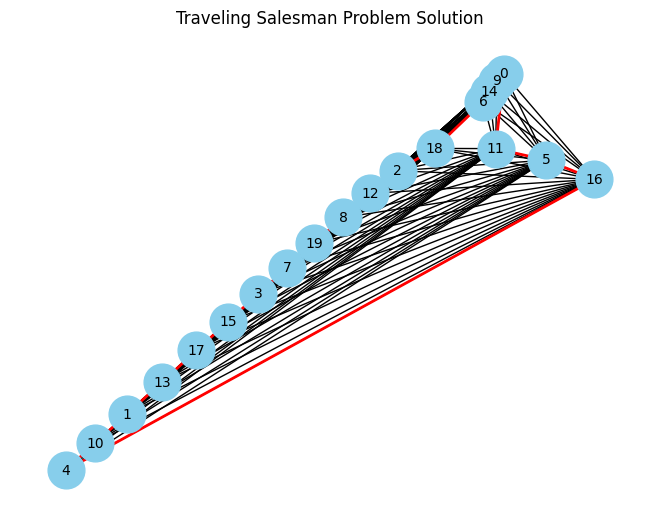

TSP Solution: [ 4 10  1 13 17 15  3  7 19  8 12  2 18  6 14  9  0 11  5 16]


In [436]:
points = kmeans.cluster_centers_
# Calculate distance matrix
distance_matrix = (kmeans.cluster_centers_[np.newaxis, :, :] - kmeans.cluster_centers_[:, np.newaxis, :])**2
distance_matrix = np.sqrt(np.sum(distance_matrix, axis=-1))

num_points = len(points)

# Create a complete graph
G = nx.complete_graph(num_points)

# Assign distances as edge weights
for i in range(num_points):
    for j in range(num_points):
        if i != j:
            G[i][j]['weight'] = distance_matrix[i][j]

# Solve TSP using networkx
tsp_solution = np.array(nx.approximation.traveling_salesman_problem(G, cycle=False))

# Convert TSP solution to edge list
tsp_edges = [(tsp_solution[i], tsp_solution[i+1]) for i in range(len(tsp_solution)-1)]
tsp_edges.append((tsp_solution[-1], tsp_solution[0]))  # Add edge from last node to first node to complete the cycle

# Plot the graph with points and edges
pos = {i: points[i] for i in range(num_points)}
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, edge_color='r', width=2)
plt.title('Traveling Salesman Problem Solution')
plt.show()

print("TSP Solution:", tsp_solution)


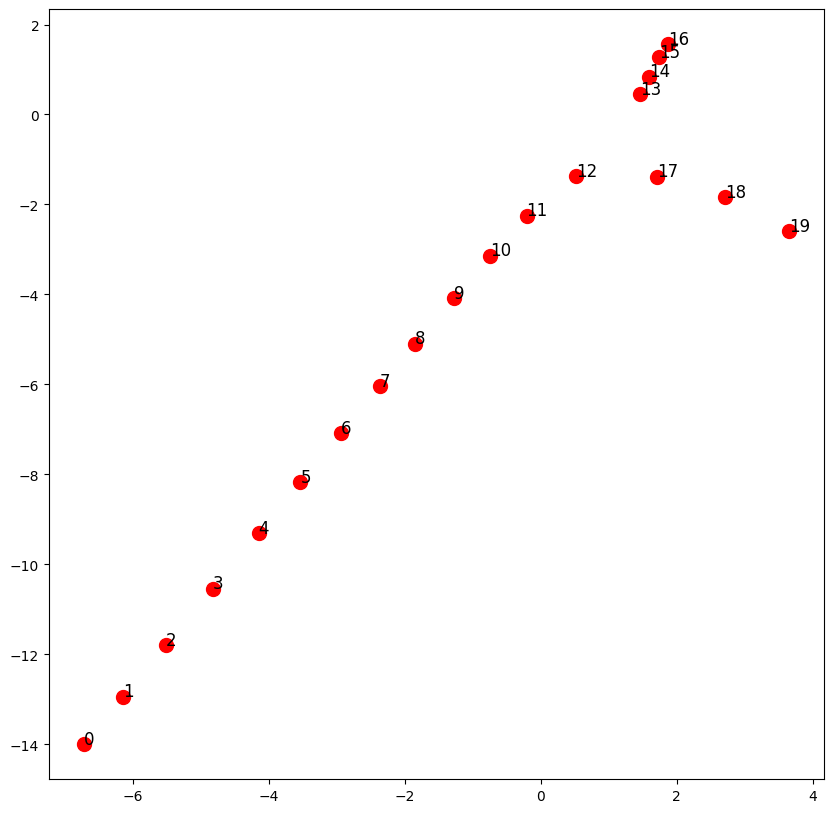

In [439]:
# plot the tsp solution
plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], s=100, c='r')
for txt, i in enumerate(tsp_solution):
    plt.annotate(txt, (points[i, 0], points[i, 1]), fontsize=12)

In [440]:
clusters_center = kmeans.cluster_centers_.mean(axis=0)
farthest_cluster = np.argmax(np.linalg.norm(kmeans.cluster_centers_ - clusters_center, axis=1))

# Reorder the tsp solution to start from the farthest cluster
start_idx = np.where(tsp_solution == farthest_cluster)[0][0]
tsp_solution = np.roll(tsp_solution, -start_idx)

# Now we change the labels of the clusters
new_labels = np.zeros_like(labels)
for i, cluster in enumerate(tsp_solution):
    new_labels[labels == cluster] = i

t['clusters'] = new_labels

In [489]:
with open('clusters.html', 'r') as f:
    html_content = f.read()
writer.add_text("Plotly Graph", html_content, global_step=0)

NameError: name 'writer' is not defined

In [447]:
plot_variable(t, 'clusters', colormap = cm.plasma)

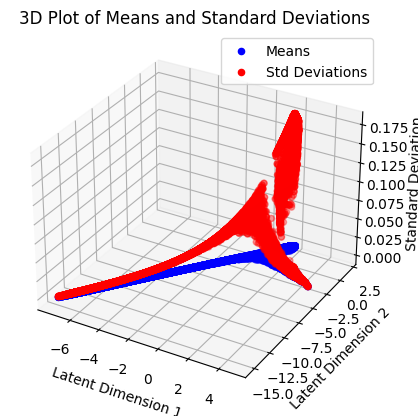

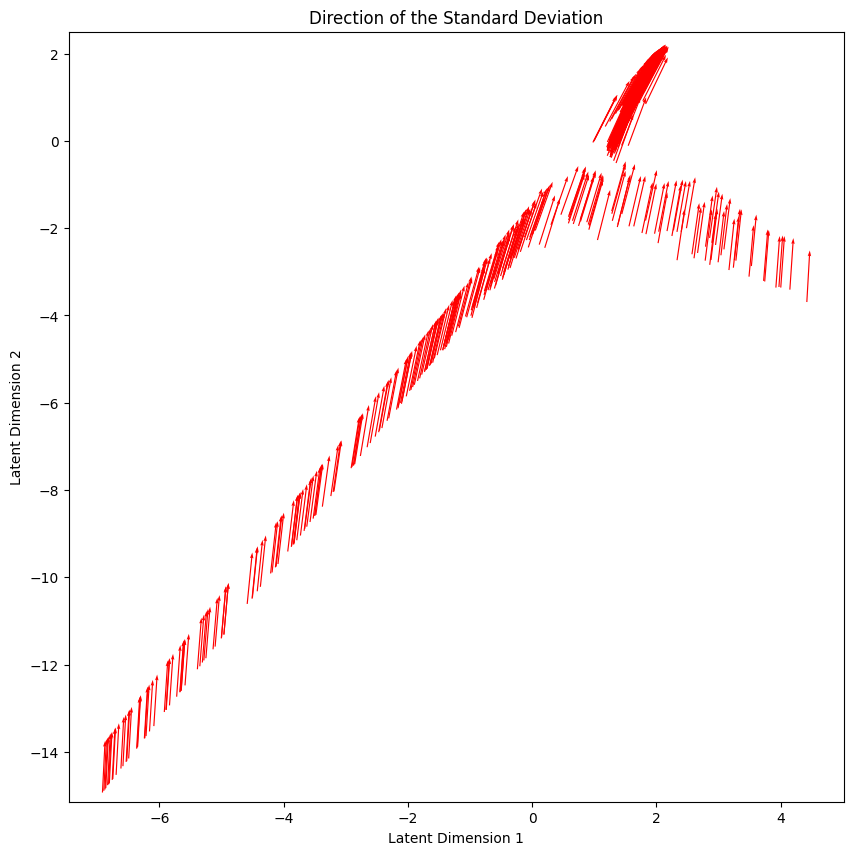

In [488]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the standard deviations for each dimension
std_y = torch.exp(0.5 * logvar[:, 0]).cpu().detach().numpy()
std_x = torch.exp(0.5 * logvar[:, 1]).cpu().detach().numpy()

# Plot the means and standard deviations
ax.scatter(mean[:, 0].cpu().detach().numpy(), mean[:, 1].cpu().detach().numpy(), zs=0, c='b', label='Means')
ax.scatter(mean[:, 0].cpu().detach().numpy(), mean[:, 1].cpu().detach().numpy(), zs=std_x, c='r', label='Std Deviations')

# Add labels and title to the plot
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Standard Deviation')
ax.set_title('3D Plot of Means and Standard Deviations')

# Add a legend
ax.legend()

# Show the plot
plt.show()

# # Now using plotly
# fig = go.Figure(data=[go.Scatter3d(
#     x=mean[:, 0].cpu().detach().numpy(),
#     y=mean[:, 1].cpu().detach().numpy(),
#     z=np.zeros_like(mean[:, 0].cpu().detach().numpy()),
#     mode='markers',
#     marker=dict(
#         size=12,
#         color='blue',                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.8
#     )
# )])

# fig.add_trace(go.Scatter3d(
#     x=mean[:, 0].cpu().detach().numpy(),
#     y=mean[:, 1].cpu().detach().numpy(),
#     z=torch.exp(0.5 * logvar[:, 0]).cpu().detach().numpy(),
#     mode='markers',
#     marker=dict(
#         size=12,
#         color='red',                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.8
#     )
# ))

# fig.show()

# now we dot a plot of the direction of the standard deviation

# select the first 1000 points
mask = np.random.choice(len(mean), 1000, replace=False)

direction = np.stack([std_x, std_y], axis=-1)[mask]
direction /= np.linalg.norm(direction, axis=-1)[:, np.newaxis]
# Plot the direction of the standard deviation
plt.figure(figsize=(10, 10))
plt.quiver(mean[:, 0].cpu().detach().numpy()[mask], mean[:, 1].cpu().detach().numpy()[mask], direction[:, 0], direction[:, 1], scale=15, pivot='mid', color='r', width=0.0015)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Direction of the Standard Deviation')
plt.show()
